In [1]:
import numpy as np
import cv2
from numba import cuda
import math
import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display


In [2]:
import os
# Prompt the user for the file path
file_path = input("Please enter the file path (.png, .jpg, .jpeg, .tif, .txt, .csv): ")

# Check if the file exists
if not os.path.isfile(file_path):
    print("File not found. Please check the path and try again.")
else:
    # Determine the file extension
    _, file_extension = os.path.splitext(file_path)
    file_extension = file_extension.lower()


Please enter the file path (.png, .jpg, .jpeg, .tif, .txt, .csv):  /home/jovyan/data-store/home/tswetnam/old_backups/USB/Postdoctoral_Projects/Self_affinity/hierarchical_branching_networks/blonder_aspen.tif


In [3]:
def load_image_file(file_path):
    import cv2
    # Load the image in unchanged mode to preserve bit depth
    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError("The file is not a valid image or is corrupted.")
    else:
        # Convert to grayscale if it's a color image
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Check data type and normalize accordingly
        if img.dtype == np.uint16:
            print("16-bit image detected.")
            max_intensity = 65535
        elif img.dtype == np.uint8:
            print("8-bit image detected.")
            max_intensity = 255
        else:
            print(f"{img.dtype} image detected.")
            max_intensity = img.max()
        
        # Normalize the image to the range [0, max_intensity]
        img = cv2.normalize(img, None, 0, max_intensity, cv2.NORM_MINMAX).astype(img.dtype)
        
        return img, max_intensity


In [4]:
def load_large_float_file(file_path):
    import numpy as np

    # Determine the delimiter based on the file extension
    delimiter = ',' if file_path.endswith('.csv') else None  # None means any whitespace

    # Get the file size
    file_size = os.path.getsize(file_path)
    print(f"File size: {file_size / (1024 ** 3):.2f} GB")

    # Read the first line to check for header and estimate columns
    with open(file_path, 'r') as f:
        first_line = f.readline()
        # Try to parse the first line as floats
        try:
            first_values = [float(val) for val in first_line.strip().split(delimiter)]
            header = False
            num_cols = len(first_values)
            print("No header detected.")
        except ValueError:
            # First line is not numeric, assume it's a header
            header = True
            print("Header detected. Skipping the header line.")
            # Read the next line to get number of columns
            second_line = f.readline()
            first_values = [float(val) for val in second_line.strip().split(delimiter)]
            num_cols = len(first_values)
        # Close the file to reset the pointer
        f.close()

    # Read the data into a list of arrays
    data_list = []
    chunk_size = 10 ** 6  # Adjust based on available memory
    total_rows = 0
    max_value = -np.inf
    min_value = np.inf

    print("Reading the data in chunks...")
    with open(file_path, 'r') as f:
        if header:
            next(f)  # Skip the header line
        for i, line in enumerate(f):
            values = line.strip().split(delimiter)
            try:
                values = [float(val) for val in values]
            except ValueError:
                print(f"Non-numeric data found on line {i+2 if header else i+1}. Skipping this line.")
                continue  # Skip lines with non-numeric data
            data_list.append(values)
            if len(data_list) >= chunk_size:
                chunk_array = np.array(data_list, dtype=np.float32)
                max_value = max(max_value, np.nanmax(chunk_array))
                min_value = min(min_value, np.nanmin(chunk_array))
                total_rows += chunk_array.shape[0]
                data_list = []  # Reset the list for the next chunk

        # Handle the last chunk
        if data_list:
            chunk_array = np.array(data_list, dtype=np.float32)
            max_value = max(max_value, np.nanmax(chunk_array))
            min_value = min(min_value, np.nanmin(chunk_array))
            total_rows += chunk_array.shape[0]

    print(f"Total rows: {total_rows}, Columns per row: {num_cols}")
    print(f"Data range: min={min_value}, max={max_value}")

    # Concatenate all chunks to form the full array
    # Note: For very large datasets, consider processing without concatenation
    img = np.array(data_list, dtype=np.float32)
    max_intensity = max_value

    return img, max_intensity



In [5]:
from numba import cuda

# CUDA kernel for computing N(s) for a given scale s
@cuda.jit
def compute_ns(img, s, Ns, max_intensity):
    y, x = cuda.grid(2)
    rows, cols = img.shape
    nx = (cols + s - 1) // s  # Number of boxes along x
    ny = (rows + s - 1) // s  # Number of boxes along y

    if x < nx and y < ny:
        z_min = max_intensity
        z_max = 0
        for i in range(s):
            for j in range(s):
                xi = x * s + i
                yj = y * s + j
                if xi < cols and yj < rows:
                    val = img[yj, xi]
                    if val < z_min:
                        z_min = val
                    if val > z_max:
                        z_max = val
        n = math.ceil((z_max - z_min) / s) + 1
        Ns[y, x] = n


In [6]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Enable interactive plotting
%matplotlib widget

# Prompt the user for the file path
file_path = input("Please enter the file path (.png, .jpg, .jpeg, .tif, .txt, .csv): ")

# Check if the file exists
if not os.path.isfile(file_path):
    print("File not found. Please check the path and try again.")
else:
    # Determine the file extension
    _, file_extension = os.path.splitext(file_path)
    file_extension = file_extension.lower()
    
    # Function to load image files
    def load_image_file(file_path):
        import cv2
        # Load the image in unchanged mode to preserve bit depth
        img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise ValueError("The file is not a valid image or is corrupted.")
        else:
            # Convert to grayscale if it's a color image
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
            # Check data type and normalize accordingly
            if img.dtype == np.uint16:
                print("16-bit image detected.")
                max_intensity = 65535
            elif img.dtype == np.uint8:
                print("8-bit image detected.")
                max_intensity = 255
            else:
                print(f"{img.dtype} image detected.")
                max_intensity = img.max()
            
            # Normalize the image to the range [0, max_intensity]
            img = cv2.normalize(img, None, 0, max_intensity, cv2.NORM_MINMAX).astype(img.dtype)
            
            return img, max_intensity
    
    # Function to load large float files with header handling
    def load_large_float_file(file_path):
        import numpy as np

        # Determine the delimiter based on the file extension
        delimiter = ',' if file_path.endswith('.csv') else None  # None means any whitespace

        # Get the file size
        file_size = os.path.getsize(file_path)
        print(f"File size: {file_size / (1024 ** 3):.2f} GB")

        # Read the first line to check for header and estimate columns
        with open(file_path, 'r') as f:
            first_line = f.readline()
            # Try to parse the first line as floats
            try:
                first_values = [float(val) for val in first_line.strip().split(delimiter)]
                header = False
                num_cols = len(first_values)
                print("No header detected.")
            except ValueError:
                # First line is not numeric, assume it's a header
                header = True
                print("Header detected. Skipping the header line.")
                # Read the next line to get number of columns
                second_line = f.readline()
                first_values = [float(val) for val in second_line.strip().split(delimiter)]
                num_cols = len(first_values)
            # Close the file to reset the pointer
            f.close()

        # Read the data into a list of arrays
        data_list = []
        chunk_size = 10 ** 6  # Adjust based on available memory
        total_rows = 0
        max_value = -np.inf
        min_value = np.inf

        print("Reading the data in chunks...")
        with open(file_path, 'r') as f:
            if header:
                next(f)  # Skip the header line
            for i, line in enumerate(f):
                values = line.strip().split(delimiter)
                try:
                    values = [float(val) for val in values]
                except ValueError:
                    print(f"Non-numeric data found on line {i+2 if header else i+1}. Skipping this line.")
                    continue  # Skip lines with non-numeric data
                data_list.append(values)
                if len(data_list) >= chunk_size:
                    chunk_array = np.array(data_list, dtype=np.float32)
                    max_value = max(max_value, np.nanmax(chunk_array))
                    min_value = min(min_value, np.nanmin(chunk_array))
                    total_rows += chunk_array.shape[0]
                    data_list = []  # Reset the list for the next chunk

            # Handle the last chunk
            if data_list:
                chunk_array = np.array(data_list, dtype=np.float32)
                max_value = max(max_value, np.nanmax(chunk_array))
                min_value = min(min_value, np.nanmin(chunk_array))
                total_rows += chunk_array.shape[0]

        print(f"Total rows: {total_rows}, Columns per row: {num_cols}")
        print(f"Data range: min={min_value}, max={max_value}")

        # Concatenate all chunks to form the full array
        img = np.array(data_list, dtype=np.float32)
        max_intensity = max_value

        return img, max_intensity
    
    # Main code block
    try:
        if file_extension in ['.png', '.jpg', '.jpeg', '.tif']:
            img, max_intensity = load_image_file(file_path)
        elif file_extension in ['.txt', '.csv']:
            img, max_intensity = load_large_float_file(file_path)
        else:
            raise ValueError("Unsupported file type.")
        
        image_name = os.path.basename(file_path)
        print(f"Loaded File: {image_name}")
        
        # Create an interactive figure
        fig, ax = plt.subplots()
        im = ax.imshow(img, cmap='gray', origin='upper')
        ax.set_title('Loaded Data')
        ax.axis('on')  # Show axes to display coordinates
        
        # Enable zooming and panning
        fig.canvas.toolbar_visible = True
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False

        # Function to handle clicks
        def onclick(event):
            if event.inaxes == ax:
                x = int(event.xdata + 0.5)
                y = int(event.ydata + 0.5)
                if x >= 0 and x < img.shape[1] and y >= 0 and y < img.shape[0]:
                    pixel_value = img[y, x]
                    print(f"Clicked at x={x}, y={y}, value={pixel_value}")
                else:
                    print("Clicked outside image bounds")
        
        # Connect the click event handler
        cid = fig.canvas.mpl_connect('button_press_event', onclick)
        plt.show()
    except Exception as e:
        print(f"Error: {e}")


RuntimeError: 'widget is not a recognised GUI loop or backend name

8-bit image detected.
Loaded File: blonder_aspen.tif


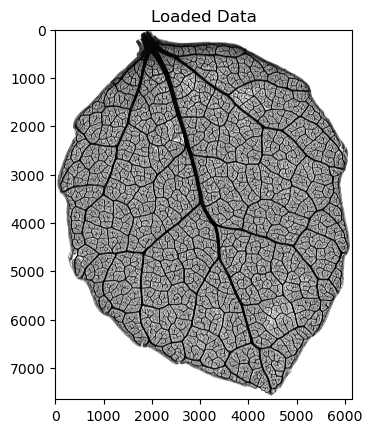

In [12]:
try:
    if file_extension in ['.png', '.jpg', '.jpeg', '.tif']:
        img, max_intensity = load_image_file(file_path)
    elif file_extension in ['.txt', '.csv']:
        img, max_intensity = load_large_float_file(file_path)
    else:
        raise ValueError("Unsupported file type.")
    
    image_name = os.path.basename(file_path)
    print(f"Loaded File: {image_name}")
    plt.imshow(img, cmap='gray')
    plt.title('Loaded Data')
    plt.axis('on')
    plt.show()
except Exception as e:
    print(f"Error: {e}")


In [13]:
from numba import cuda

# CUDA kernel for computing N(s) for a given scale s
@cuda.jit
def compute_ns(img, s, Ns, max_intensity):
    y, x = cuda.grid(2)
    rows, cols = img.shape
    nx = (cols + s - 1) // s  # Number of boxes along x
    ny = (rows + s - 1) // s  # Number of boxes along y

    if x < nx and y < ny:
        z_min = max_intensity
        z_max = 0.0
        for i in range(s):
            for j in range(s):
                xi = x * s + i
                yj = y * s + j
                if xi < cols and yj < rows:
                    val = img[yj, xi]
                    if val < z_min:
                        z_min = val
                    if val > z_max:
                        z_max = val
        n = math.ceil((z_max - z_min) / s) + 1
        Ns[y, x] = n


In [14]:
def compute_fractal_dimension(img, scales, max_intensity):
    Ns_list = []
    inv_scales = []
    for s in scales:
        nx = (img.shape[1] + s - 1) // s
        ny = (img.shape[0] + s - 1) // s
        Ns = np.zeros((ny, nx), dtype=np.int32)
        
        # Prepare the image and Ns arrays for CUDA
        img_device = cuda.to_device(img)
        Ns_device = cuda.to_device(Ns)
        
        # CUDA grid and block dimensions
        threadsperblock = (16, 16)
        blockspergrid_x = (nx + threadsperblock[1] - 1) // threadsperblock[1]
        blockspergrid_y = (ny + threadsperblock[0] - 1) // threadsperblock[0]
        blockspergrid = (blockspergrid_y, blockspergrid_x)
        
        # Launch CUDA kernel
        compute_ns[blockspergrid, threadsperblock](img_device, s, Ns_device, max_intensity)
        cuda.synchronize()
        
        # Copy the result back to host
        Ns = Ns_device.copy_to_host()
        
        N = Ns.sum()
        Ns_list.append(N)
        inv_scales.append(1/s)
        
        print(f"Scale: {s}, N(s): {N}")
        
    # Linear fit to estimate the fractal dimension
    log_Ns = np.log(Ns_list)
    log_inv_scales = np.log(inv_scales)
    coeffs = np.polyfit(log_inv_scales, log_Ns, 1)
    fractal_dimension = coeffs[0]
    return fractal_dimension, log_inv_scales, log_Ns



In [15]:
if 'img' in globals():
    # Define scales (adjust based on image size)
    min_scale = 2
    max_scale = min(img.shape) // 4  # Maximum scale to consider
    num_scales = 5  # Number of scales to evaluate
    scales = [int(min_scale * (2 ** i)) for i in range(num_scales) if min_scale * (2 ** i) <= max_scale]
    
    if not scales:
        scales = [2, 4]  # Fallback scales if image is too small
    
    print(f"Scales to be used: {scales}")
    
    fractal_dimension, log_inv_scales, log_Ns = compute_fractal_dimension(img, scales, max_intensity)
    print(f"\nEstimated Fractal Dimension: {fractal_dimension:.4f}")
else:
    print("Image not loaded. Please provide a valid image path.")



Scales to be used: [2, 4, 8, 16, 32]
Scale: 2, N(s): 150730395
Scale: 4, N(s): 43765109
Scale: 8, N(s): 9008751
Scale: 16, N(s): 1666865
Scale: 32, N(s): 282917

Estimated Fractal Dimension: 2.2829


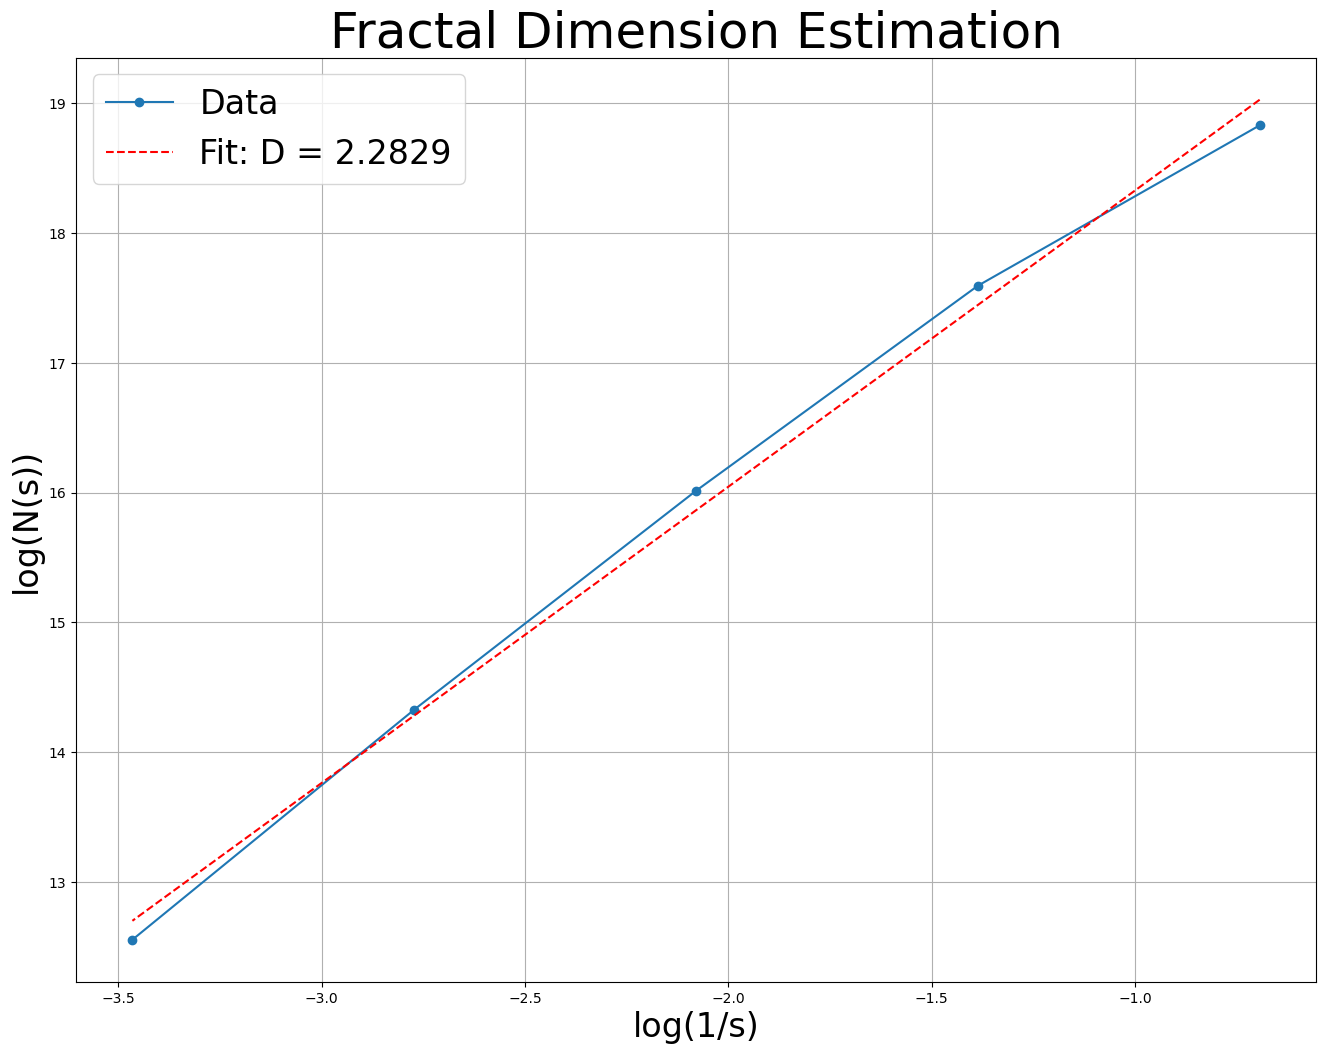

In [16]:
if 'img' in globals():
    # Plotting the log-log plot
    plt.figure(figsize=(16, 12))
    plt.plot(log_inv_scales, log_Ns, 'o-', label='Data')
    # Plot the fitted line
    coeffs = np.polyfit(log_inv_scales, log_Ns, 1)
    plt.plot(log_inv_scales, np.polyval(coeffs, log_inv_scales), 'r--', label=f'Fit: D = {coeffs[0]:.4f}')
    plt.xlabel('log(1/s)', fontsize=24)
    plt.ylabel('log(N(s))', fontsize=24)
    plt.title('Fractal Dimension Estimation', fontsize=36)
    plt.legend(fontsize=24)
    plt.grid(True)
    plt.show()
else:
    print("Image not loaded. Please provide a valid image path.")

